In [ ]:
from keras.datasets import mnist
import numpy as np
from keras import backend as k
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense,Flatten,Conv2D,MaxPooling2D,AveragePooling2D,Dropout,BatchNormalization
from keras.activations import relu,softmax
from keras.initializers import he_normal,glorot_normal,random_normal,glorot_uniform
from keras.losses import categorical_crossentropy
from keras.optimizers import Adadelta,Adam
from prettytable import PrettyTable
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from keras.utils import np_utils 


Using TensorFlow backend.


### Data overview:

In [ ]:
(X_train,y_train),(X_test,y_test)=mnist.load_data()
print("train data shape {}".format(X_train.shape))
print("test data shape {}".format(X_test.shape))
rows=X_train.shape[1]
columns=X_train.shape[2]

11493376/11490434 [==============================] - 1s 0us/step
train data shape (60000, 28, 28)
test data shape (10000, 28, 28)


### Transforming our input data according to the type of bckend we are using

In [ ]:
if k.image_data_format()=='channels_first':
  X_train=X_train.reshape(X_train.shape[0],1,rows,columns)
  X_test=X_test.reshape(X_test.shape[0],1,rows,columns)
  input_shape=(1,rows,columns)
else :
  X_train=X_train.reshape(X_train.shape[0],rows,columns,1)
  X_test=X_test.reshape(X_test.shape[0],rows,columns,1)
  input_shape=(rows,columns,1)

### Data normalization and conversion

In [ ]:
X_train=X_train.astype('float32')
X_test=X_test.astype('float32')

X_train=X_train/255
X_test=X_test/255

#converting the class labels to 10 dimensions 
y_train=np_utils.to_categorical(y_train,10)
y_test=np_utils.to_categorical(y_test,10)

print("train data shape ",X_train.shape)
print("test data shape ",X_test.shape)
print("output train labels shape ",y_train.shape)
print("output test labels shape ",y_test.shape)

train data shape  (60000, 28, 28, 1)
test data shape  (10000, 28, 28, 1)
output train labels shape  (60000, 10)
output test labels shape  (10000, 10)


In [ ]:
batch_size=100
epoches=10
num_classes=10



---



## ASSIGNMENT-14 (CNN ON MNIST DATA)

***key points:***

*   for each dense layers we have considered batch normalization and dropout rate of 0.4 as our results obtained in assignment-13.

*  In this assignment all the observations are done stepwise as:


1.   Changing the feature maps.
2.   Changing the kernel size.
3.   Changing the padding.
4.   With maxpooling and without maxpooling.
5.   With average pooling and without average pooling.
6.   Changing pool_size.
7.   Changing the number of dense layers.
8.   Affect of batch normalization on convolution layers.
9.   Affect of dropout on convolution layers.
10.   Affect of data augmentation.

*  In each succesive step the best best value we got we incorporate that value for the next steps.

* As for 7 convolution layers the computation is more So only 1 example of 7 convolution layers is depicted in the assignment.

* As Due to computaion issues the number of epochs are kept 10.

* For the pool_strides it has been kept (1,1) as we don't want to reduce our 28x28 matrix to almost 0 dimensions as it is feeded to deeper CNNs.



## [0].Some Common Functions

**0.1 Plotting the loss  and accuracy graph vs number of epochs**

In [ ]:
def plot_graph(history,model):
  print("test log-loss ",model.evaluate(X_test,y_test,verbose=0)[0])
  print("test accuracy ",model.evaluate(X_test,y_test,verbose=0)[1])
  plt.figure(figsize=(16,6))
  for i in range(1,3):
    plt.subplot(1,2,i)
    plt.grid()
    if i==1:
      plt.plot(np.arange(1,epoches+1),history.history['loss'],label="Train Loss")
      plt.plot(np.arange(1,epoches+1),history.history['val_loss'],label="Test Loss")
      plt.ylabel("cross entropy loss")
    else:
      plt.plot(np.arange(1,epoches+1),history.history['acc'],label="Train Accuracy")
      plt.plot(np.arange(1,epoches+1),history.history['val_acc'],label="Test Accuracy")
      plt.ylabel("Accuracy")
    plt.xlabel("number of epochs")
    
    plt.legend()
  plt.suptitle("Error Plots")
  
  plt.show()

**0.2 Misclassified point samples**

In [ ]:
#http://euler.stat.yale.edu/~tba3/stat665/lectures/lec18/notebook18.html
def misclassified_pts(model):
  print("Fraction of missclassified points \n",np.round(1-model2.evaluate(X_test,y_test,verbose=0)[1],3))
  print("Some Samples Of missclassified Points\n")
  y_pred=model.predict_classes(X_test)

  misclf_pts=[im for im in zip(X_test,np.argmax(y_test,axis=1),y_pred) if im[1]!=im[2]]

  plt.figure(figsize=(10,6))

  for idx,val in enumerate(misclf_pts[:25]):
    plt.subplots_adjust(left=0,right=1,top=1,bottom=0)
    #as matplotlib gives black for a low pixel value
    plt.subplot(5,5,idx+1)
    imag=1-val[0].reshape((28,28))
    plt.axis('off')
    plt.text(0,0,val[1],color='black')
    plt.text(0,10,val[2],color='red')
    plt.imshow(imag,cmap='gray')

**0.3 Getting images after data augmentation**

In [ ]:
#https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/
#https://www.kaggle.com/gimunu/data-augmentation-with-keras-into-cnn

def show_samples_of_augmented_images(datagen):
  print("Some samples after performing data augmentation")
  
  #it will return images in batches of 32
  imga,_=next(datagen.flow(X_train,y_train,batch_size=32))
  plt.figure(figsize=(10,6))

  for i in np.arange(32):
    plt.subplots_adjust(left=0,right=1,top=1,bottom=0)
    plt.subplot(4,8,i+1)
    plt.imshow(1-imga[i].reshape(28,28),cmap='gray')
    plt.xticks([],[])
    plt.yticks([],[])



---



## [1] Common Function For creating model:

In [ ]:
def create_model(nu_conv_layers,kernel_size,kernel_strides,padding,feature_maps,augmentation_done,max_pooling,avg_pooling,pool_size,pool_strides,dropout,
                 nu_dense_lyrs,size_dense_layers,BN):
  model=Sequential()
  
  
  
  #defining the initial layer
  
  model.add(Conv2D(filters=feature_maps[0],activation='relu',kernel_size=kernel_size,strides=kernel_strides,padding=padding,\
                   input_shape=input_shape,kernel_initializer=glorot_uniform()))
  if max_pooling[0]:
    model.add(MaxPooling2D(pool_size=pool_size,strides=pool_strides[0]))
  if avg_pooling[0]:
    model.add(AveragePooling2D(pool_size=pool_size,strides=pool_strides[0]))
  if BN[0]:
    model.add(BatchNormalization())
  if dropout[0]:
    model.add(Dropout(dropout[1])) 
  
  #creating intermediate layers
  
  for layer in range(1,nu_conv_layers):
      model.add(Conv2D(filters=feature_maps[layer],activation='relu',kernel_size=kernel_size,strides=kernel_strides,\
                       padding=padding,kernel_initializer=glorot_uniform()))
      
      if max_pooling[layer]:
        model.add(MaxPooling2D(pool_size=pool_size,strides=pool_strides[layer]))
      if avg_pooling[layer]:
        model.add(AveragePooling2D(pool_size=pool_size,strides=pool_strides[layer]))
      if BN[layer]:
        model.add(BatchNormalization())
      if dropout[0]:
        model.add(Dropout(dropout[1])) 
      
   
  model.add(Flatten())
  
  #adding the dense layers
  for dn_lyr in range(nu_dense_lyrs):
    model.add(Dense(size_dense_layers[dn_lyr],activation='relu',kernel_initializer=glorot_uniform()))
  #as we know adding batch normalization to dense layers always produce god result so we will use BN + dropout in the dense layers  
    
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    
  #adding the final softmax layer
  
  model.add(Dense(10,activation='softmax'))
  
  
  model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
  
  #if data augmentation is performed then we are are returning the ImageDataGenerator instance also
  #as our data is mnist we will avoid the parameters like horizontal flip ,vertical flip ,rotation of image more than 90 etc.
  #We will use the transformation that will not affect our meaning of dataset.
  
  if augmentation_done :
    datagen=ImageDataGenerator(width_shift_range=0.2,height_shift_range=0.2,rotation_range=30,shear_range=12,horizontal_flip=False,vertical_flip=False)

    #fiiting our train data to imagedata_augmentor

    datagen.fit(X_train,augment=True)
    
    history=model.fit_generator(datagen.flow(X_train,y_train,batch_size=batch_size),epochs=epoches,\
                                steps_per_epoch=X_train.shape[0]/batch_size,verbose=1,validation_data=(X_test,y_test))
    
    return history,model,datagen
  
  else :
    history=model.fit(X_train,y_train,verbose=1,epochs=epoches,batch_size=batch_size,validation_data=(X_test,y_test))
  
    return history,model
  

## [2] Changing Different Parameters On The MNIST Dataset

---





**[2.1] affect of changing the feature maps (number of filters)**

In [ ]:
history51,model51=create_model(nu_conv_layers=2,kernel_size=5,kernel_strides=(2,2),padding='same',feature_maps=[8,16],augmentation_done=False,
                               max_pooling=[False]*2,avg_pooling=[False]*2,pool_size=(2,2),pool_strides=[(1,1)]*2,dropout=[False,0.4],
                               nu_dense_lyrs=1,size_dense_layers=[128],BN=[True]*2)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 21s 343us/step - loss: 0.2529 - acc: 0.9235 - val_loss: 0.0757 - val_acc: 0.9750
Epoch 2/10
60000/60000 [==============================] - 19s 319us/step - loss: 0.0881 - acc: 0.9726 - val_loss: 0.0549 - val_acc: 0.9826
Epoch 3/10
60000/60000 [==============================] - 19s 311us/step - loss: 0.0639 - acc: 0.9800 - val_loss: 0.0444 - val_acc: 0.9844
Epoch 4/10
60000/60000 [==============================] - 19s 311us/step - loss: 0.0496 - acc: 0.9848 - val_loss: 0.0378 - val_acc: 0.9885
Epoch 5/10
60000/60000 [==============================] - 19s 309us/step - loss: 0.0436 - acc: 0.9859 - val_loss: 0.0440 - val_acc: 0.9854
Epoch 6/10
60000/60000 [==============================] - 19s 311us/step - loss: 0.0377 - acc: 0.9880 - val_loss: 0.0382 - val_acc: 0.9880
Epoch 7/10
60000/60000 [==============================] - 19s 311us/step - loss: 0.0307 - acc: 0.9903 - val_loss: 0.

In [ ]:
history52,model52=create_model(nu_conv_layers=2,kernel_size=5,kernel_strides=(2,2),padding='same',feature_maps=[2,2],augmentation_done=False,
                               max_pooling=[False]*2,avg_pooling=[False]*2,pool_size=(2,2),pool_strides=[(1,1)]*2,dropout=[False,0.4],nu_dense_lyrs=1,
                               size_dense_layers=[128],BN=[False]*2)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 12s 200us/step - loss: 0.5811 - acc: 0.8188 - val_loss: 0.1767 - val_acc: 0.9446
Epoch 2/10
60000/60000 [==============================] - 11s 180us/step - loss: 0.2042 - acc: 0.9373 - val_loss: 0.1180 - val_acc: 0.9625
Epoch 3/10
60000/60000 [==============================] - 11s 182us/step - loss: 0.1589 - acc: 0.9517 - val_loss: 0.1011 - val_acc: 0.9683
Epoch 4/10
60000/60000 [==============================] - 11s 180us/step - loss: 0.1379 - acc: 0.9583 - val_loss: 0.0931 - val_acc: 0.9686
Epoch 5/10
60000/60000 [==============================] - 11s 181us/step - loss: 0.1291 - acc: 0.9601 - val_loss: 0.0900 - val_acc: 0.9718
Epoch 6/10
60000/60000 [==============================] - 11s 180us/step - loss: 0.1169 - acc: 0.9642 - val_loss: 0.0863 - val_acc: 0.9710
Epoch 7/10
60000/60000 [==============================] - 12s 202us/step - loss: 0.1125 - acc: 0.9657 - val_loss: 0.

In [ ]:
history53,model53=create_model(nu_conv_layers=3,kernel_size=5,kernel_strides=(1,1),padding='same',feature_maps=[8,16,32],augmentation_done=False,
                               max_pooling=[False]*3,avg_pooling=[False]*3,pool_size=(2,2),pool_strides=[(1,1)]*3,dropout=[False,0.4],nu_dense_lyrs=1,
                               size_dense_layers=[128],BN=[False]*3)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 267s 4ms/step - loss: 0.1223 - acc: 0.9638 - val_loss: 0.0543 - val_acc: 0.9831
Epoch 2/10
60000/60000 [==============================] - 268s 4ms/step - loss: 0.0466 - acc: 0.9862 - val_loss: 0.0365 - val_acc: 0.9878
Epoch 3/10
60000/60000 [==============================] - 267s 4ms/step - loss: 0.0324 - acc: 0.9901 - val_loss: 0.0280 - val_acc: 0.9904
Epoch 4/10
60000/60000 [==============================] - 266s 4ms/step - loss: 0.0243 - acc: 0.9921 - val_loss: 0.0297 - val_acc: 0.9899
Epoch 5/10
60000/60000 [==============================] - 265s 4ms/step - loss: 0.0180 - acc: 0.9944 - val_loss: 0.0474 - val_acc: 0.9860
Epoch 6/10
60000/60000 [==============================] - 266s 4ms/step - loss: 0.0150 - acc: 0.9951 - val_loss: 0.0381 - val_acc: 0.9877
Epoch 7/10
60000/60000 [==============================] - 266s 4ms/step - loss: 0.0128 - acc: 0.9960 - val_loss: 0.0309 - 

In [ ]:
history54,model54=create_model(nu_conv_layers=3,kernel_size=5,kernel_strides=(2,2),padding='same',feature_maps=[4,4,4],augmentation_done=False,
                               max_pooling=[False]*3,avg_pooling=[False]*3,pool_size=(2,2),pool_strides=[(1,1)]*3,dropout=[False,0.4],nu_dense_lyrs=1,
                               size_dense_layers=[128],BN=[False]*3)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 13s 220us/step - loss: 0.5130 - acc: 0.8362 - val_loss: 0.1787 - val_acc: 0.9418
Epoch 2/10
60000/60000 [==============================] - 12s 199us/step - loss: 0.1973 - acc: 0.9404 - val_loss: 0.1120 - val_acc: 0.9666
Epoch 3/10
60000/60000 [==============================] - 12s 199us/step - loss: 0.1444 - acc: 0.9557 - val_loss: 0.1061 - val_acc: 0.9659
Epoch 4/10
60000/60000 [==============================] - 12s 198us/step - loss: 0.1206 - acc: 0.9636 - val_loss: 0.0794 - val_acc: 0.9736
Epoch 5/10
60000/60000 [==============================] - 12s 200us/step - loss: 0.1091 - acc: 0.9667 - val_loss: 0.0750 - val_acc: 0.9764
Epoch 6/10
60000/60000 [==============================] - 12s 202us/step - loss: 0.0990 - acc: 0.9694 - val_loss: 0.0751 - val_acc: 0.9760
Epoch 7/10
60000/60000 [==============================] - 12s 199us/step - loss: 0.0914 - acc: 0.9719 - val_loss: 0.

**[2.1.1] Effect Of Using Different Number Of Kernels**

In [ ]:
pt_fm=PrettyTable()
pt_fm.field_names=["conv2D layers","nu_filters","train loss","test loss","test accuracy"]
pt_fm.add_row([2,"8 || 16",np.round(history51.history['loss'][9],3),
               np.round(model51.evaluate(X_test,y_test,verbose=0)[0],3),np.round(model51.evaluate(X_test,y_test,verbose=0)[1],3)])
               
pt_fm.add_row([2,"2 ||2",np.round(history52.history['loss'][9],3),
               np.round(model52.evaluate(X_test,y_test,verbose=0)[0],3),np.round(model52.evaluate(X_test,y_test,verbose=0)[1],3)])
               
pt_fm.add_row([3,"8||16||32",np.round(history53.history['loss'][9],3),
               np.round(model53.evaluate(X_test,y_test,verbose=0)[0],3),np.round(model53.evaluate(X_test,y_test,verbose=0)[1],3)])
               
pt_fm.add_row([3,"4||4||4",np.round(history54.history['loss'][9],3),
               np.round(model54.evaluate(X_test,y_test,verbose=0)[0],3),np.round(model54.evaluate(X_test,y_test,verbose=0)[1],3)])
print("effect of number of filters on cnn performance keeping other parameters same")
print(pt_fm)


effect of number of filters on cnn performance keeping other parameters same
+---------------+------------+------------+-----------+---------------+
| conv2D layers | nu_filters | train loss | test loss | test accuracy |
+---------------+------------+------------+-----------+---------------+
|       2       |  8 || 16   |   0.024    |   0.038   |     0.988     |
|       2       |   2 ||2    |    0.1     |   0.068   |     0.977     |
|       3       | 8||16||32  |    0.01    |   0.031   |     0.991     |
|       3       |  4||4||4   |   0.077    |    0.06   |      0.98     |
+---------------+------------+------------+-----------+---------------+


***CONCLUSIONS***


*   The number of feature maps should considerable increase for later layers as initial layers are just to detect edges and later layers are used to detect the  little details from an image.So the more number of feature maps we have the more details we have.


---






**[3.2] affect of the kernel_size**

In [ ]:
#(7,7)
history55,model55=create_model(nu_conv_layers=3,kernel_size=7,kernel_strides=(1,1),padding='valid',feature_maps=[8,16,32],augmentation_done=False,
                               max_pooling=[False]*3,avg_pooling=[False]*3,pool_size=(2,2),pool_strides=[(1,1)]*3,dropout=[False,0.4],nu_dense_lyrs=1,
                               size_dense_layers=[128],BN=[False]*3)

In [ ]:
#(3,3)
history56,model56=create_model(nu_conv_layers=3,kernel_size=3,kernel_strides=(1,1),padding='valid',feature_maps=[8,16,32],augmentation_done=False,
                               max_pooling=[False]*3,avg_pooling=[False]*3,pool_size=(2,2),pool_strides=[(1,1)]*3,dropout=[False,0.4],nu_dense_lyrs=1,
                               size_dense_layers=[128],BN=[False]*3)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 96s 2ms/step - loss: 0.1411 - acc: 0.9580 - val_loss: 0.1191 - val_acc: 0.9657
Epoch 2/10
60000/60000 [==============================] - 93s 2ms/step - loss: 0.0564 - acc: 0.9831 - val_loss: 0.0487 - val_acc: 0.9836
Epoch 3/10
60000/60000 [==============================] - 92s 2ms/step - loss: 0.0410 - acc: 0.9877 - val_loss: 0.0466 - val_acc: 0.9845
Epoch 4/10
60000/60000 [==============================] - 92s 2ms/step - loss: 0.0308 - acc: 0.9903 - val_loss: 0.0533 - val_acc: 0.9844
Epoch 5/10
60000/60000 [==============================] - 91s 2ms/step - loss: 0.0242 - acc: 0.9923 - val_loss: 0.0320 - val_acc: 0.9892
Epoch 6/10
60000/60000 [==============================] - 90s 2ms/step - loss: 0.0182 - acc: 0.9939 - val_loss: 0.0342 - val_acc: 0.9890
Epoch 7/10
60000/60000 [==============================] - 91s 2ms/step - loss: 0.0160 - acc: 0.9949 - val_loss: 0.0365 - val_acc

In [ ]:
history539,model539=create_model(nu_conv_layers=3,kernel_size=5,kernel_strides=(1,1),padding='valid',feature_maps=[8,16,32],augmentation_done=False,
                               max_pooling=[False]*3,avg_pooling=[False]*3,pool_size=(2,2),pool_strides=[(1,1)]*3,dropout=[False,0.4],nu_dense_lyrs=1,
                               size_dense_layers=[128],BN=[False]*3)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 105s 2ms/step - loss: 0.1305 - acc: 0.9616 - val_loss: 0.0450 - val_acc: 0.9851
Epoch 2/10
60000/60000 [==============================] - 104s 2ms/step - loss: 0.0505 - acc: 0.9851 - val_loss: 0.0698 - val_acc: 0.9771
Epoch 3/10
60000/60000 [==============================] - 104s 2ms/step - loss: 0.0372 - acc: 0.9885 - val_loss: 0.0352 - val_acc: 0.9869
Epoch 4/10
60000/60000 [==============================] - 103s 2ms/step - loss: 0.0285 - acc: 0.9915 - val_loss: 0.0322 - val_acc: 0.9897
Epoch 5/10
60000/60000 [==============================] - 103s 2ms/step - loss: 0.0237 - acc: 0.9929 - val_loss: 0.0359 - val_acc: 0.9894
Epoch 6/10
60000/60000 [==============================] - 102s 2ms/step - loss: 0.0179 - acc: 0.9947 - val_loss: 0.0286 - val_acc: 0.9906
Epoch 7/10
60000/60000 [==============================] - 102s 2ms/step - loss: 0.0156 - acc: 0.9954 - val_loss: 0.0342 - 

**[3.2.1] comparing  on kernel sizes**

In [ ]:
pt_ks=PrettyTable()
pt_ks.field_names=["conv_layers","kernels size used","padding","train loss","test loss","test accuracy"]

pt_ks.add_row([3,(3,3),'valid',np.round(history56.history['loss'][9],3),
               np.round(model56.evaluate(X_test,y_test,verbose=0)[0],3),np.round(model56.evaluate(X_test,y_test,verbose=0)[1],3)])

pt_ks.add_row([3,(5,5),'valid',np.round(history539.history['loss'][9],3),
               np.round(model539.evaluate(X_test,y_test,verbose=0)[0],3),np.round(model539.evaluate(X_test,y_test,verbose=0)[1],3)])

pt_ks.add_row([3,(7,7),'valid',np.round(history55.history['loss'][9],3),
               np.round(model55.evaluate(X_test,y_test,verbose=0)[0],3),np.round(model55.evaluate(X_test,y_test,verbose=0)[1],3)])

print("Affect Of Kernel Sizes On Test loss And Accuracy keeping other parameters same")
print(pt_ks)


Affect Of Kernel Sizes On Test loss And Accuracy keeping other parameters same
+-------------+-------------------+---------+------------+-----------+---------------+
| conv_layers | kernels size used | padding | train loss | test loss | test accuracy |
+-------------+-------------------+---------+------------+-----------+---------------+
|      3      |       (3, 3)      |  valid  |   0.009    |   0.041   |     0.989     |
|      3      |       (5, 5)      |  valid  |   0.013    |   0.028   |     0.992     |
|      3      |       (7, 7)      |  valid  |   0.021    |   0.029   |     0.991     |
+-------------+-------------------+---------+------------+-----------+---------------+


***CONCLUSIONS***


*  kernel should be kept of size medium (5,5).As having too small kernels will include extra informations/pixels and large kernels will skip the important pixel/edge features.


---






**[3.3] affect of padding**

In [ ]:
#here we have to keep in mind that we should carefully choose the number of layers and kernel size such that our original dimensions do not vanish
history561,model561=create_model(nu_conv_layers=3,kernel_size=5,kernel_strides=(1,1),padding='valid',feature_maps=[8,16,32],augmentation_done=False,
                               max_pooling=[False]*3,avg_pooling=[False]*3,pool_size=(2,2),pool_strides=[(1,1)]*3,dropout=[False,0.4],nu_dense_lyrs=1,
                               size_dense_layers=[128],BN=[False]*3)


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 103s 2ms/step - loss: 0.1253 - acc: 0.9636 - val_loss: 0.0408 - val_acc: 0.9875
Epoch 2/10
60000/60000 [==============================] - 102s 2ms/step - loss: 0.0472 - acc: 0.9860 - val_loss: 0.0281 - val_acc: 0.9907
Epoch 3/10
60000/60000 [==============================] - 102s 2ms/step - loss: 0.0362 - acc: 0.9889 - val_loss: 0.0413 - val_acc: 0.9864
Epoch 4/10
60000/60000 [==============================] - 102s 2ms/step - loss: 0.0262 - acc: 0.9920 - val_loss: 0.0322 - val_acc: 0.9896
Epoch 5/10
60000/60000 [==============================] - 102s 2ms/step - loss: 0.0228 - acc: 0.9929 - val_loss: 0.0300 - val_acc: 0.9906
Epoch 6/10
60000/60000 [==============================] - 102s 2ms/step - loss: 0.0185 - acc: 0.9943 - val_loss: 0.0342 - val_acc: 0.9889
Epoch 7/10
60000/60000 [==============================] - 105s 2ms/step - loss: 0.0161 - acc: 0.9950 - val_loss: 0.0296 - 

**[3.3.1] summarizing the result**

In [ ]:
pt_pd=PrettyTable()
pt_pd.field_names=["conv_layers","kernel size","padding","train loss","test loss","test accuracy"]
pt_pd.add_row([3,(5,5),'valid',np.round(history561.history['loss'][9],3),
               np.round(model561.evaluate(X_test,y_test,verbose=0)[0],3),np.round(model561.evaluate(X_test,y_test,verbose=0)[1],3)])

pt_pd.add_row([3,(5,5),'same',np.round(history53.history['loss'][9],3),
               np.round(model53.evaluate(X_test,y_test,verbose=0)[0],3),np.round(model53.evaluate(X_test,y_test,verbose=0)[1],3)])
print("Affect Of padding On Test loss And Accuracy keeping other parameters same")
print(pt_pd)

Affect Of padding On Test loss And Accuracy keeping other parameters same
+-------------+-------------+---------+------------+-----------+---------------+
| conv_layers | kernel size | padding | train loss | test loss | test accuracy |
+-------------+-------------+---------+------------+-----------+---------------+
|      3      |    (5, 5)   |  valid  |   0.011    |   0.032   |      0.99     |
|      3      |    (5, 5)   |   same  |    0.01    |   0.031   |     0.991     |
+-------------+-------------+---------+------------+-----------+---------------+


***CONCLUSION***


*   padding='valid' is better option in place of 'same' untill and unless our original matrix do not vanishes before last layer.
* padding='same' is used commonly if somehow due to succesive convolution and maxpool operations the matrix vanishes.



---




**[3.4] affect of adding maxpooling layer**

In [ ]:
#adding maxpool everywhere
history57,model57=create_model(nu_conv_layers=3,kernel_size=5,kernel_strides=(1,1),padding='valid',feature_maps=[8,16,32],augmentation_done=False,
                               max_pooling=[True]*3,avg_pooling=[False]*3,pool_size=(2,2),pool_strides=[(1,1)]*3,dropout=[False,0.4],nu_dense_lyrs=1,
                               size_dense_layers=[128],BN=[False]*3)

In [ ]:
#without maxpooling on 5 convolution layer architecture
history58,model58=create_model(nu_conv_layers=5,kernel_size=5,kernel_strides=(1,1),padding='valid',feature_maps=[8,16,24,32,40],augmentation_done=False,
                               max_pooling=[False]*5,avg_pooling=[False]*5,pool_size=(2,2),pool_strides=[(1,1)]*5,dropout=[False,0.4],nu_dense_lyrs=1,
                               size_dense_layers=[128],BN=[False]*5)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 154s 3ms/step - loss: 0.1676 - acc: 0.9504 - val_loss: 0.0727 - val_acc: 0.9768
Epoch 2/10
60000/60000 [==============================] - 151s 3ms/step - loss: 0.0599 - acc: 0.9819 - val_loss: 0.0374 - val_acc: 0.9879
Epoch 3/10
60000/60000 [==============================] - 151s 3ms/step - loss: 0.0484 - acc: 0.9857 - val_loss: 0.0674 - val_acc: 0.9784
Epoch 4/10
60000/60000 [==============================] - 151s 3ms/step - loss: 0.0381 - acc: 0.9883 - val_loss: 0.0413 - val_acc: 0.9877
Epoch 5/10
60000/60000 [==============================] - 151s 3ms/step - loss: 0.0358 - acc: 0.9892 - val_loss: 0.0349 - val_acc: 0.9894
Epoch 6/10
60000/60000 [==============================] - 152s 3ms/step - loss: 0.0299 - acc: 0.9912 - val_loss: 0.0259 - val_acc: 0.9914
Epoch 7/10
60000/60000 [==============================] - 154s 3ms/step - loss: 0.0268 - acc: 0.9918 - val_loss: 0.0264 - 

In [ ]:
#with maxpooling on 5 conv layer(EVERYWHERE)
history59,model59=create_model(nu_conv_layers=5,kernel_size=5,kernel_strides=(1,1),padding='valid',feature_maps=[8,16,24,32,40],augmentation_done=False,
                               max_pooling=[True]*5,avg_pooling=[False]*5,pool_size=(2,2),pool_strides=[(1,1)]*5,dropout=[False,0.4],nu_dense_lyrs=1,
                               size_dense_layers=[128],BN=[False]*5)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 125s 2ms/step - loss: 0.2038 - acc: 0.9387 - val_loss: 0.1501 - val_acc: 0.9527
Epoch 2/10
60000/60000 [==============================] - 122s 2ms/step - loss: 0.0770 - acc: 0.9771 - val_loss: 0.0785 - val_acc: 0.9745
Epoch 3/10
60000/60000 [==============================] - 121s 2ms/step - loss: 0.0593 - acc: 0.9818 - val_loss: 0.0816 - val_acc: 0.9714
Epoch 4/10
60000/60000 [==============================] - 119s 2ms/step - loss: 0.0502 - acc: 0.9849 - val_loss: 0.0768 - val_acc: 0.9753
Epoch 5/10
60000/60000 [==============================] - 119s 2ms/step - loss: 0.0445 - acc: 0.9863 - val_loss: 0.0403 - val_acc: 0.9865
Epoch 6/10
60000/60000 [==============================] - 120s 2ms/step - loss: 0.0412 - acc: 0.9872 - val_loss: 0.0401 - val_acc: 0.9874
Epoch 7/10
60000/60000 [==============================] - 121s 2ms/step - loss: 0.0365 - acc: 0.9883 - val_loss: 0.0642 - 

In [ ]:
#with maxpooling on 5 conv layer(INITIAL LAYERS ONLY)
history5_1,model5_1=create_model(nu_conv_layers=5,kernel_size=5,kernel_strides=(1,1),padding='valid',feature_maps=[8,16,24,32,40],augmentation_done=False,
                               max_pooling=[True,True,True,False,False],avg_pooling=[False]*5,pool_size=(2,2),pool_strides=[(1,1)]*5,
                                 dropout=[False,0.4],nu_dense_lyrs=1,size_dense_layers=[128],BN=[False]*5)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 127s 2ms/step - loss: 0.1795 - acc: 0.9461 - val_loss: 0.0847 - val_acc: 0.9752
Epoch 2/10
60000/60000 [==============================] - 124s 2ms/step - loss: 0.0704 - acc: 0.9789 - val_loss: 0.0615 - val_acc: 0.9811
Epoch 3/10
60000/60000 [==============================] - 123s 2ms/step - loss: 0.0542 - acc: 0.9842 - val_loss: 0.0436 - val_acc: 0.9865
Epoch 4/10
60000/60000 [==============================] - 123s 2ms/step - loss: 0.0458 - acc: 0.9862 - val_loss: 0.0470 - val_acc: 0.9854
Epoch 5/10
60000/60000 [==============================] - 123s 2ms/step - loss: 0.0419 - acc: 0.9878 - val_loss: 0.0529 - val_acc: 0.9842
Epoch 6/10
60000/60000 [==============================] - 124s 2ms/step - loss: 0.0380 - acc: 0.9883 - val_loss: 0.0302 - val_acc: 0.9914
Epoch 7/10
60000/60000 [==============================] - 124s 2ms/step - loss: 0.0324 - acc: 0.9899 - val_loss: 0.0288 - 

**[3.4.1] summarizing results obtained**

In [ ]:
pt_mp=PrettyTable()
pt_mp.field_names=["conv2D layers","kernel","padding","max_pooling","train loss","test loss","test accuracy"]
pt_mp.add_row([3,"(5,5)",'valid',"0--0--0",np.round(history561.history['loss'][9],3),
              np.round(model561.evaluate(X_test,y_test,verbose=0)[0],3),np.round(model561.evaluate(X_test,y_test,verbose=0)[1],3)])

pt_mp.add_row([3,"(5,5)",'valid',"1--1--1",np.round(history57.history['loss'][9],3),
              np.round(model57.evaluate(X_test,y_test,verbose=0)[0],3),np.round(model57.evaluate(X_test,y_test,verbose=0)[1],3)])

pt_mp.add_row([5,"(5,5)",'valid',"0-0-0-0-0",np.round(history58.history['loss'][9],3),
              np.round(model58.evaluate(X_test,y_test,verbose=0)[0],3),np.round(model58.evaluate(X_test,y_test,verbose=0)[1],3)])

pt_mp.add_row([5,"(5,5)",'valid',"1-1-1-0-0",np.round(history5_1.history['loss'][9],3),
              np.round(model5_1.evaluate(X_test,y_test,verbose=0)[0],3),np.round(model5_1.evaluate(X_test,y_test,verbose=0)[1],3)])

pt_mp.add_row([5,"(5,5)",'valid',"1-1-1-1-1",np.round(history59.history['loss'][9],3),
              np.round(model59.evaluate(X_test,y_test,verbose=0)[0],3),np.round(model59.evaluate(X_test,y_test,verbose=0)[1],3)])

print("effect of maxpool layer on cnn performance keeping other parameters same")
print(pt_mp)

effect of maxpool layer on cnn performance keeping other parameters same
+---------------+--------+---------+-------------+------------+-----------+---------------+
| conv2D layers | kernel | padding | max_pooling | train loss | test loss | test accuracy |
+---------------+--------+---------+-------------+------------+-----------+---------------+
|       3       | (5,5)  |  valid  |   0--0--0   |   0.011    |   0.032   |      0.99     |
|       3       | (5,5)  |  valid  |   1--1--1   |   0.019    |   0.022   |     0.992     |
|       5       | (5,5)  |  valid  |  0-0-0-0-0  |    0.02    |   0.029   |     0.992     |
|       5       | (5,5)  |  valid  |  1-1-1-0-0  |   0.026    |   0.038   |     0.989     |
|       5       | (5,5)  |  valid  |  1-1-1-1-1  |   0.029    |   0.044   |     0.986     |
+---------------+--------+---------+-------------+------------+-----------+---------------+


***CONCLUSIONS***


*   maxpool is used for location invariance of objects in an image.As we have simple mnist data so that maybe the reason maxpool is not working that much good here because all we have is 1 object in given image(i.e the number)



---




**[3.5] Using Average Pooling**

In [ ]:
#with average pooling on 3 layers
history5611,model5611=create_model(nu_conv_layers=3,kernel_size=5,kernel_strides=(1,1),padding='valid',feature_maps=[8,16,32],augmentation_done=False,
                               max_pooling=[False]*3,avg_pooling=[True]*3,pool_size=(2,2),pool_strides=[(1,1)]*3,dropout=[False,0.4],nu_dense_lyrs=1,
                               size_dense_layers=[128],BN=[False]*3)

In [ ]:
#with average pooling on 5 layers
history581,model581=create_model(nu_conv_layers=5,kernel_size=5,kernel_strides=(1,1),padding='valid',feature_maps=[8,16,24,32,40],augmentation_done=False,
                               max_pooling=[False]*5,avg_pooling=[True]*5,pool_size=(2,2),pool_strides=[(1,1)]*5,dropout=[False,0.4],nu_dense_lyrs=1,
                               size_dense_layers=[128],BN=[False]*5)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 117s 2ms/step - loss: 0.2113 - acc: 0.9352 - val_loss: 0.1385 - val_acc: 0.9576
Epoch 2/10
60000/60000 [==============================] - 115s 2ms/step - loss: 0.0785 - acc: 0.9769 - val_loss: 0.0680 - val_acc: 0.9775
Epoch 3/10
60000/60000 [==============================] - 113s 2ms/step - loss: 0.0609 - acc: 0.9820 - val_loss: 0.0486 - val_acc: 0.9844
Epoch 4/10
60000/60000 [==============================] - 112s 2ms/step - loss: 0.0528 - acc: 0.9842 - val_loss: 0.0464 - val_acc: 0.9853
Epoch 5/10
60000/60000 [==============================] - 112s 2ms/step - loss: 0.0453 - acc: 0.9860 - val_loss: 0.0360 - val_acc: 0.9890
Epoch 6/10
60000/60000 [==============================] - 115s 2ms/step - loss: 0.0410 - acc: 0.9875 - val_loss: 0.0324 - val_acc: 0.9890
Epoch 7/10
60000/60000 [==============================] - 114s 2ms/step - loss: 0.0368 - acc: 0.9888 - val_loss: 0.0506 - 

**[3.5.1] Summarizing the results**

In [ ]:
pt_ap=PrettyTable()
pt_ap.field_names=["conv2D layers","kernel","padding","avg_pooling?","train loss","test loss","test accuracy"]
pt_ap.add_row([3,"(5,5)",'valid',"No",np.round(history561.history['loss'][9],3),
              np.round(model561.evaluate(X_test,y_test,verbose=0)[0],3),np.round(model561.evaluate(X_test,y_test,verbose=0)[1],3)])

pt_ap.add_row([3,"(5,5)",'valid',"Yes",np.round(history5611.history['loss'][9],3),
              np.round(model5611.evaluate(X_test,y_test,verbose=0)[0],3),np.round(model5611.evaluate(X_test,y_test,verbose=0)[1],3)])

pt_ap.add_row([5,"(5,5)",'valid',"No",np.round(history58.history['loss'][9],3),
              np.round(model58.evaluate(X_test,y_test,verbose=0)[0],3),np.round(model58.evaluate(X_test,y_test,verbose=0)[1],3)])

pt_ap.add_row([5,"(5,5)",'valid',"Yes",np.round(history581.history['loss'][9],3),
              np.round(model581.evaluate(X_test,y_test,verbose=0)[0],3),np.round(model581.evaluate(X_test,y_test,verbose=0)[1],3)])

print(pt_ap)

+---------------+--------+---------+--------------+------------+-----------+---------------+
| conv2D layers | kernel | padding | avg_pooling? | train loss | test loss | test accuracy |
+---------------+--------+---------+--------------+------------+-----------+---------------+
|       3       | (5,5)  |  valid  |      No      |   0.011    |   0.032   |      0.99     |
|       3       | (5,5)  |  valid  |     Yes      |    0.02    |   0.023   |     0.993     |
|       5       | (5,5)  |  valid  |      No      |    0.02    |   0.029   |     0.992     |
|       5       | (5,5)  |  valid  |     Yes      |    0.03    |   0.035   |      0.99     |
+---------------+--------+---------+--------------+------------+-----------+---------------+


* average pooling working slightly better than maxpooling but still the results are better if we don't use any pooling methods.

---



**[3.6] Affect of adding different pool_size**

In [ ]:
#(4,4)  pool_size
history5_2,model5_2=create_model(nu_conv_layers=3,kernel_size=5,kernel_strides=(1,1),padding='valid',feature_maps=[8,16,32],augmentation_done=False,
                               max_pooling=[False]*3,avg_pooling=[False]*3,pool_size=(4,4),pool_strides=[(1,1)]*3,dropout=[False,0.4],nu_dense_lyrs=1,
                               size_dense_layers=[128],BN=[False]*3)


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 110s 2ms/step - loss: 0.1283 - acc: 0.9627 - val_loss: 0.0480 - val_acc: 0.9841
Epoch 2/10
60000/60000 [==============================] - 105s 2ms/step - loss: 0.0509 - acc: 0.9848 - val_loss: 0.0439 - val_acc: 0.9861
Epoch 3/10
60000/60000 [==============================] - 105s 2ms/step - loss: 0.0364 - acc: 0.9889 - val_loss: 0.0364 - val_acc: 0.9886
Epoch 4/10
60000/60000 [==============================] - 105s 2ms/step - loss: 0.0284 - acc: 0.9913 - val_loss: 0.0367 - val_acc: 0.9890
Epoch 5/10
60000/60000 [==============================] - 106s 2ms/step - loss: 0.0247 - acc: 0.9923 - val_loss: 0.0279 - val_acc: 0.9891
Epoch 6/10
60000/60000 [==============================] - 106s 2ms/step - loss: 0.0203 - acc: 0.9932 - val_loss: 0.0286 - val_acc: 0.9911
Epoch 7/10
60000/60000 [==============================] - 105s 2ms/step - loss: 0.0176 - acc: 0.9944 - val_loss: 0.0200 - 

In [ ]:
#(6,6)
history5_3,model5_3=create_model(nu_conv_layers=3,kernel_size=5,kernel_strides=(1,1),padding='valid',feature_maps=[8,16,32],augmentation_done=False,
                               max_pooling=[False]*3,avg_pooling=[False]*3,pool_size=(6,6),pool_strides=[(1,1)]*3,dropout=[False,0.4],nu_dense_lyrs=1,
                               size_dense_layers=[128],BN=[False]*3)


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 109s 2ms/step - loss: 0.1235 - acc: 0.9632 - val_loss: 0.0478 - val_acc: 0.9844
Epoch 2/10
60000/60000 [==============================] - 106s 2ms/step - loss: 0.0474 - acc: 0.9851 - val_loss: 0.0383 - val_acc: 0.9874
Epoch 3/10
60000/60000 [==============================] - 106s 2ms/step - loss: 0.0355 - acc: 0.9889 - val_loss: 0.0409 - val_acc: 0.9879
Epoch 4/10
60000/60000 [==============================] - 105s 2ms/step - loss: 0.0268 - acc: 0.9917 - val_loss: 0.0556 - val_acc: 0.9822
Epoch 5/10
60000/60000 [==============================] - 105s 2ms/step - loss: 0.0221 - acc: 0.9930 - val_loss: 0.0318 - val_acc: 0.9905
Epoch 6/10
60000/60000 [==============================] - 105s 2ms/step - loss: 0.0199 - acc: 0.9935 - val_loss: 0.0308 - val_acc: 0.9905
Epoch 7/10
60000/60000 [==============================] - 105s 2ms/step - loss: 0.0159 - acc: 0.9950 - val_loss: 0.0362 - 

**[3.6.1] summarizing the results**

In [ ]:
pt_ps=PrettyTable()
pt_ps.field_names=["conv2D layers","kernel size","padding","maxpool/avgpool?","poolsize","train loss","test loss","test accuracy"]
pt_ps.add_row([3,"(5,5)","valid",'NO',(2,2),np.round(history57.history['loss'][9],3),
              np.round(model561.evaluate(X_test,y_test,verbose=0)[0],3),np.round(model561.evaluate(X_test,y_test,verbose=0)[1],3)])

pt_ps.add_row([3,"(5,5)","valid",'No',(4,4),np.round(history5_2.history['loss'][9],3),
              np.round(model5_2.evaluate(X_test,y_test,verbose=0)[0],2),np.round(model5_2.evaluate(X_test,y_test,verbose=0)[1],3)])

pt_ps.add_row([3,"(5,5)","valid",'No',(6,6),np.round(history5_3.history['loss'][9],3),
              np.round(model5_3.evaluate(X_test,y_test,verbose=0)[0],3),np.round(model5_3.evaluate(X_test,y_test,verbose=0)[1],3)])
print("effect of different pool size on cnn performance keeping other parameters same")
print(pt_ps)

effect of different pool size on cnn performance keeping other parameters same
+---------------+-------------+---------+------------------+----------+------------+-----------+---------------+
| conv2D layers | kernel size | padding | maxpool/avgpool? | poolsize | train loss | test loss | test accuracy |
+---------------+-------------+---------+------------------+----------+------------+-----------+---------------+
|       3       |    (5,5)    |  valid  |        NO        |  (2, 2)  |   0.019    |   0.032   |      0.99     |
|       3       |    (5,5)    |  valid  |        No        |  (4, 4)  |   0.011    |    0.03   |     0.992     |
|       3       |    (5,5)    |  valid  |        No        |  (6, 6)  |    0.01    |   0.027   |     0.991     |
+---------------+-------------+---------+------------------+----------+------------+-----------+---------------+


**[3.7] effect of adding more number of dense layers**

In [ ]:
history5_4,model5_4=create_model(nu_conv_layers=3,kernel_size=5,kernel_strides=(1,1),padding='valid',feature_maps=[8,16,32],augmentation_done=False,
                               max_pooling=[False]*3,avg_pooling=[False]*3,pool_size=(2,2),pool_strides=[(1,1)]*3,dropout=[False,0.4],nu_dense_lyrs=2,
                               size_dense_layers=[32,16],BN=[False]*3)

history5_5,model5_5=create_model(nu_conv_layers=3,kernel_size=5,kernel_strides=(1,1),padding='valid',feature_maps=[8,16,32],augmentation_done=False,
                               max_pooling=[False]*3,avg_pooling=[False]*3,pool_size=(2,2),pool_strides=[(1,1)]*3,dropout=[False,0.4],nu_dense_lyrs=3,
                               size_dense_layers=[64,32,16],BN=[False]*3)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 98s 2ms/step - loss: 0.7039 - acc: 0.7966 - val_loss: 0.0741 - val_acc: 0.9787
Epoch 2/10
60000/60000 [==============================] - 94s 2ms/step - loss: 0.2690 - acc: 0.9232 - val_loss: 0.0498 - val_acc: 0.9848
Epoch 3/10
60000/60000 [==============================] - 95s 2ms/step - loss: 0.1976 - acc: 0.9425 - val_loss: 0.0566 - val_acc: 0.9833
Epoch 4/10
60000/60000 [==============================] - 93s 2ms/step - loss: 0.1678 - acc: 0.9502 - val_loss: 0.0385 - val_acc: 0.9878
Epoch 5/10
60000/60000 [==============================] - 92s 2ms/step - loss: 0.1412 - acc: 0.9574 - val_loss: 0.0428 - val_acc: 0.9870
Epoch 6/10
60000/60000 [==============================] - 92s 2ms/step - loss: 0.1369 - acc: 0.9572 - val_loss: 0.0365 - val_acc: 0.9896
Epoch 7/10
60000/60000 [==============================] - 93s 2ms/step - loss: 0.1195 - acc: 0.9630 - val_loss: 0.0330 - val_acc

In [ ]:
history5_5_1,model5_5_1=create_model(nu_conv_layers=3,kernel_size=5,kernel_strides=(1,1),padding='valid',feature_maps=[8,16,32],augmentation_done=False,
                               max_pooling=[False]*3,avg_pooling=[False]*3,pool_size=(2,2),pool_strides=[(1,1)]*3,dropout=[False,0.4],nu_dense_lyrs=3,
                               size_dense_layers=[64,32,16,8],BN=[False]*3)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 103s 2ms/step - loss: 0.8434 - acc: 0.7410 - val_loss: 0.0888 - val_acc: 0.9773
Epoch 2/10
60000/60000 [==============================] - 99s 2ms/step - loss: 0.3087 - acc: 0.9148 - val_loss: 0.0484 - val_acc: 0.9846
Epoch 3/10
60000/60000 [==============================] - 99s 2ms/step - loss: 0.2158 - acc: 0.9408 - val_loss: 0.0378 - val_acc: 0.9886
Epoch 4/10
60000/60000 [==============================] - 99s 2ms/step - loss: 0.1661 - acc: 0.9553 - val_loss: 0.0392 - val_acc: 0.9888
Epoch 5/10
60000/60000 [==============================] - 99s 2ms/step - loss: 0.1480 - acc: 0.9600 - val_loss: 0.0447 - val_acc: 0.9874
Epoch 6/10
60000/60000 [==============================] - 99s 2ms/step - loss: 0.1316 - acc: 0.9646 - val_loss: 0.0340 - val_acc: 0.9912
Epoch 7/10
60000/60000 [==============================] - 99s 2ms/step - loss: 0.1228 - acc: 0.9680 - val_loss: 0.0310 - val_ac

**[3.7.1] summarizing the result**

In [ ]:
pt_dl=PrettyTable()
pt_dl.field_names=["conv2D layers","kernel","padding","maxpool/avgpool?","poolsize","num_dense_layers","train_loss","test loss","test accuracy"]
pt_dl.add_row([3,"(5,5)","valid","No","(2,2)",1,np.round(history57.history['loss'][9],3),
              np.round(model57.evaluate(X_test,y_test,verbose=0)[0],3),np.round(model57.evaluate(X_test,y_test,verbose=0)[1],3)])

pt_dl.add_row([3,"(5,5)","valid","No","(2,2)",2,np.round(history5_4.history['loss'][9],3),
              np.round(model5_4.evaluate(X_test,y_test,verbose=0)[0],3),np.round(model5_4.evaluate(X_test,y_test,verbose=0)[1],3)])

pt_dl.add_row([3,"(5,5)","valid","No","(2,2)",3,np.round(history5_5.history['loss'][9],3),
              np.round(model5_5.evaluate(X_test,y_test,verbose=0)[0],3),np.round(model5_5.evaluate(X_test,y_test,verbose=0)[1],3)])

pt_dl.add_row([3,"(5,5)","valid","No","(2,2)",4,np.round(history5_5_1.history['loss'][9],3),
              np.round(model5_5_1.evaluate(X_test,y_test,verbose=0)[0],3),np.round(model5_5_1.evaluate(X_test,y_test,verbose=0)[1],3)])

print("effect of different dense layers cnn performance keeping other parameters same")
print(pt_dl)

effect of different dense layers cnn performance keeping other parameters same
+---------------+--------+---------+------------------+----------+------------------+------------+-----------+---------------+
| conv2D layers | kernel | padding | maxpool/avgpool? | poolsize | num_dense_layers | train_loss | test loss | test accuracy |
+---------------+--------+---------+------------------+----------+------------------+------------+-----------+---------------+
|       3       | (5,5)  |  valid  |        No        |  (2,2)   |        1         |   0.019    |   0.022   |     0.992     |
|       3       | (5,5)  |  valid  |        No        |  (2,2)   |        2         |   0.105    |   0.038   |      0.99     |
|       3       | (5,5)  |  valid  |        No        |  (2,2)   |        3         |   0.096    |   0.042   |      0.99     |
|       3       | (5,5)  |  valid  |        No        |  (2,2)   |        4         |   0.095    |    0.03   |     0.992     |
+---------------+--------+------



---



**[3.8] affect of adding batch normalization**

In [ ]:
#without BN to 3 conv layer architecture
history5_41,model5_41=create_model(nu_conv_layers=3,kernel_size=5,kernel_strides=(1,1),padding='valid',feature_maps=[8,16,32],augmentation_done=False,
                               max_pooling=[False]*3,avg_pooling=[False]*3,pool_size=(2,2),pool_strides=[(1,1)]*3,dropout=[False,0.4],nu_dense_lyrs=3,
                               size_dense_layers=[64,32,16],BN=[False]*3)

#adding BN to 3 conv layer
historyn_1,modeln_1=create_model(nu_conv_layers=3,kernel_size=5,kernel_strides=(1,1),padding='valid',feature_maps=[8,16,32],augmentation_done=False,
                               max_pooling=[False]*3,avg_pooling=[False]*3,pool_size=(2,2),pool_strides=[(1,1)]*3,dropout=[False,0.4],nu_dense_lyrs=3,
                               size_dense_layers=[64,32,16],BN=[True]*3)

#adding batch normalization to dense layers only
history5_6,model5_6=create_model(nu_conv_layers=5,kernel_size=5,kernel_strides=(1,1),padding='valid',feature_maps=[8,16,24,32,32],augmentation_done=False,
                               max_pooling=[False]*5,avg_pooling=[False]*5,pool_size=(2,2),pool_strides=[(1,1)]*5,
                                 dropout=[False,0.4],nu_dense_lyrs=3,size_dense_layers=[64,32,16],BN=[False]*5)

#applying BN to all layers
history5_7,model5_7=create_model(nu_conv_layers=5,kernel_size=5,kernel_strides=(1,1),padding='valid',feature_maps=[8,16,24,32,32],augmentation_done=False,
                               max_pooling=[False]*5,avg_pooling=[False]*5,pool_size=(2,2),pool_strides=[(1,1)]*5,
                                 dropout=[False,0.4],nu_dense_lyrs=3,size_dense_layers=[64,32,16],BN=[True]*5)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 104s 2ms/step - loss: 0.8117 - acc: 0.7534 - val_loss: 0.0866 - val_acc: 0.9777
Epoch 2/10
60000/60000 [==============================] - 98s 2ms/step - loss: 0.2870 - acc: 0.9221 - val_loss: 0.1136 - val_acc: 0.9685
Epoch 3/10
60000/60000 [==============================] - 98s 2ms/step - loss: 0.1985 - acc: 0.9476 - val_loss: 0.0473 - val_acc: 0.9866
Epoch 4/10
60000/60000 [==============================] - 98s 2ms/step - loss: 0.1557 - acc: 0.9578 - val_loss: 0.0353 - val_acc: 0.9901
Epoch 5/10
60000/60000 [==============================] - 98s 2ms/step - loss: 0.1388 - acc: 0.9628 - val_loss: 0.0364 - val_acc: 0.9898
Epoch 6/10
60000/60000 [==============================] - 99s 2ms/step - loss: 0.1133 - acc: 0.9703 - val_loss: 0.0369 - val_acc: 0.9914
Epoch 7/10
60000/60000 [==============================] - 99s 2ms/step - loss: 0.1019 - acc: 0.9716 - val_loss: 0.0530 - val_ac

**[3.8.1] Summarizing the result**

In [ ]:
pt_bn=PrettyTable()
pt_bn.field_names=["conv2D layers","kernel","padding","maxpool/avgpool?","poolsize","dense layers","batch_normalization_on_convlayers"
                   ,"train loss","test loss","test accuracy"]

pt_bn.add_row([3,"(5,5)","valid","No","(2,2)",3,"No",np.round(history5_41.history['loss'][9],3),
               np.round(model5_41.evaluate(X_test,y_test,verbose=0)[0],3),np.round(model5_41.evaluate(X_test,y_test,verbose=0)[1],3)])

pt_bn.add_row([3,"(5,5)","valid","No","(2,2)",3,"Yes",np.round(historyn_1.history['loss'][9],3),
               np.round(modeln_1.evaluate(X_test,y_test,verbose=0)[0],3),np.round(modeln_1.evaluate(X_test,y_test,verbose=0)[1],3)])

pt_bn.add_row([5,"(5,5)","valid","No","(2,2)",3,"No",np.round(history5_6.history['loss'][9],3),
               np.round(model5_6.evaluate(X_test,y_test,verbose=0)[0],3),np.round(model5_6.evaluate(X_test,y_test,verbose=0)[1],3)])

pt_bn.add_row([5,"(5,5)","valid","No","(2,2)",3,"Yes",np.round(history5_7.history['loss'][9],3),
               np.round(model5_7.evaluate(X_test,y_test,verbose=0)[0],3),np.round(model5_7.evaluate(X_test,y_test,verbose=0)[1],3)])
print("effect of batch bormalization on cnn performance keeping other parameters same")
print(pt_bn)

effect of batch bormalization on cnn performance keeping other parameters same
+---------------+--------+---------+------------------+----------+--------------+-----------------------------------+------------+-----------+---------------+
| conv2D layers | kernel | padding | maxpool/avgpool? | poolsize | dense layers | batch_normalization_on_convlayers | train loss | test loss | test accuracy |
+---------------+--------+---------+------------------+----------+--------------+-----------------------------------+------------+-----------+---------------+
|       3       | (5,5)  |  valid  |        No        |  (2,2)   |      3       |                 No                |   0.081    |   0.036   |     0.993     |
|       3       | (5,5)  |  valid  |        No        |  (2,2)   |      3       |                Yes                |   0.077    |   0.041   |     0.989     |
|       5       | (5,5)  |  valid  |        No        |  (2,2)   |      3       |                 No                |   0.097 



---



**[3.9] Affect of dropout rate On Convolution Layers**

In [ ]:
#Dropout =0.1
history5_8,model5_8=create_model(nu_conv_layers=3,kernel_size=5,kernel_strides=(1,1),padding='valid',feature_maps=[8,16,32],augmentation_done=False,
                               max_pooling=[False]*3,avg_pooling=[False]*3,pool_size=(2,2),pool_strides=[(1,1)]*3,dropout=[True,0.1],nu_dense_lyrs=2,
                               size_dense_layers=[32,16],BN=[True]*3)
#dropout=0.5
history5_9,model5_9=create_model(nu_conv_layers=3,kernel_size=5,kernel_strides=(1,1),padding='valid',feature_maps=[8,16,32],augmentation_done=False,
                               max_pooling=[False]*3,avg_pooling=[False]*3,pool_size=(2,2),pool_strides=[(1,1)]*3,dropout=[True,0.5],nu_dense_lyrs=2,
                               size_dense_layers=[32,16],BN=[True]*3)

#dropout=0.8
history5_10,model5_10=create_model(nu_conv_layers=3,kernel_size=5,kernel_strides=(1,1),padding='valid',feature_maps=[8,16,32],augmentation_done=False,
                               max_pooling=[False]*3,avg_pooling=[False]*3,pool_size=(2,2),pool_strides=[(1,1)]*3,dropout=[True,0.8],nu_dense_lyrs=2,
                               size_dense_layers=[32,16],BN=[True]*3)

**[3.9.1] Summarizing the result**

In [ ]:
pt_dr=PrettyTable()
pt_dr.field_names=["conv2D layers","kernel","padding","maxpool/avgpool?","pool_size","num_dense_layers","BN","Drp_out_conv_layer",
                   "train loss","test loss","test accuracy"]
pt_dr.add_row([3,"(5,5)","valid","No","(2,2)",3,"Yes","No",np.round(historyn_1.history['loss'][9],3)
               ,np.round(modeln_1.evaluate(X_test,y_test,verbose=0)[0],3),np.round(modeln_1.evaluate(X_test,y_test,verbose=0)[1],3)])

pt_dr.add_row([3,"(5,5)","valid","No","(2,2)",2,"Yes",0.1,np.round(history5_8.history['loss'][9],3)
               ,np.round(model5_8.evaluate(X_test,y_test,verbose=0)[0],3),np.round(model5_8.evaluate(X_test,y_test,verbose=0)[1],3)])

pt_dr.add_row([3,"(5,5)","valid","No","(2,2)",2,"Yes",0.5,np.round(history5_9.history['loss'][9],3)
               ,np.round(model5_9.evaluate(X_test,y_test,verbose=0)[0],3),np.round(model5_9.evaluate(X_test,y_test,verbose=0)[1],3)])

pt_dr.add_row([3,"(5,5)","valid","No","(2,2)",2,"Yes",0.8,np.round(history5_10.history['loss'][9],3)
               ,np.round(model5_10.evaluate(X_test,y_test,verbose=0)[0],3),np.round(model5_10.evaluate(X_test,y_test,verbose=0)[1],3)])

print("effect of different Dropout Rates On cnn performance keeping other parameters same")
print(pt_dr)

effect of different Dropout Rates On cnn performance keeping other parameters same
+---------------+--------+---------+------------------+-----------+------------------+-----+--------------------+------------+-----------+---------------+
| conv2D layers | kernel | padding | maxpool/avgpool? | pool_size | num_dense_layers |  BN | Drp_out_conv_layer | train loss | test loss | test accuracy |
+---------------+--------+---------+------------------+-----------+------------------+-----+--------------------+------------+-----------+---------------+
|       3       | (5,5)  |  valid  |        No        |   (2,2)   |        3         | Yes |         No         |   0.077    |   0.041   |     0.989     |
|       3       | (5,5)  |  valid  |        No        |   (2,2)   |        2         | Yes |        0.1         |    0.07    |   0.033   |     0.992     |
|       3       | (5,5)  |  valid  |        No        |   (2,2)   |        2         | Yes |        0.5         |   0.119    |    0.03   |    



---



**[3.10] affect of data augmentation**

In [ ]:
history5_11,model5_11,datagen_11=create_model(nu_conv_layers=3,kernel_size=5,kernel_strides=(1,1),padding='valid',feature_maps=[8,16,32],augmentation_done=True,
                               max_pooling=[False]*3,avg_pooling=[False]*3,pool_size=(2,2),pool_strides=[(1,1)]*5,dropout=[True,0.5],nu_dense_lyrs=3,
                               size_dense_layers=[64,32,16],BN=[True]*3)


Epoch 1/10
600/600 [==============================] - 174s 290ms/step - loss: 2.1610 - acc: 0.2493 - val_loss: 1.1506 - val_acc: 0.6195
Epoch 2/10
600/600 [==============================] - 165s 275ms/step - loss: 1.5114 - acc: 0.4647 - val_loss: 0.6754 - val_acc: 0.7689
Epoch 3/10
600/600 [==============================] - 165s 275ms/step - loss: 1.1328 - acc: 0.6145 - val_loss: 0.3360 - val_acc: 0.9356
Epoch 4/10
600/600 [==============================] - 165s 275ms/step - loss: 0.8935 - acc: 0.7198 - val_loss: 0.1774 - val_acc: 0.9569
Epoch 5/10
600/600 [==============================] - 165s 275ms/step - loss: 0.7181 - acc: 0.7832 - val_loss: 0.1425 - val_acc: 0.9617
Epoch 6/10
600/600 [==============================] - 165s 276ms/step - loss: 0.6424 - acc: 0.8145 - val_loss: 0.1244 - val_acc: 0.9641
Epoch 7/10
600/600 [==============================] - 166s 277ms/step - loss: 0.5785 - acc: 0.8363 - val_loss: 0.1041 - val_acc: 0.9689
Epoch 8/10
600/600 [============================

**[3.10.1] Visualizing Some Samples Of Augmented Images**

Some samples after performing data augmentation


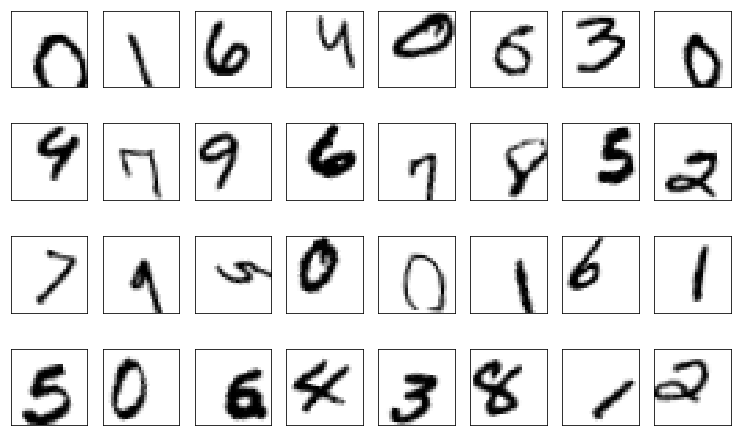

In [ ]:
show_samples_of_augmented_images(datagen_11)

**[3.10.2] summarizing the results**

In [ ]:
pt_aug=PrettyTable()
pt_aug.field_names=["conv2D layers","kernel","padding","max_pooling/avgpool?","pool_size","dense layers","BN","dropout","data_augmentation",
                    "train loss","test loss","test accuracy"]

pt_aug.add_row([3,"(5,5)","valid","No","(2,2)",3,"Yes",0.5,"No",np.round(history5_9.history['loss'][9],3),
                np.round(modeln_1.evaluate(X_test,y_test,verbose=0)[0],3),np.round(modeln_1.evaluate(X_test,y_test,verbose=0)[1],3)])

pt_aug.add_row([3,"(5,5)","valid","No","(2,2)",3,"Yes",0.5,"Yes",np.round(history5_11.history['loss'][9],3),
                np.round(model5_11.evaluate(X_test,y_test,verbose=0)[0],3),np.round(model5_11.evaluate(X_test,y_test,verbose=0)[1],3)])
print("effect of Data Augmentation on cnn performance keeping other parameters same")
print(pt_aug)

effect of Data Augmentation on cnn performance keeping other parameters same
+---------------+--------+---------+----------------------+-----------+--------------+-----+---------+-------------------+------------+-----------+---------------+
| conv2D layers | kernel | padding | max_pooling/avgpool? | pool_size | dense layers |  BN | dropout | data_augmentation | train loss | test loss | test accuracy |
+---------------+--------+---------+----------------------+-----------+--------------+-----+---------+-------------------+------------+-----------+---------------+
|       3       | (5,5)  |  valid  |          No          |   (2,2)   |      3       | Yes |   0.5   |         No        |   0.119    |   0.041   |     0.989     |
|       3       | (5,5)  |  valid  |          No          |   (2,2)   |      3       | Yes |   0.5   |        Yes        |   0.485    |   0.092   |     0.973     |
+---------------+--------+---------+----------------------+-----------+--------------+-----+---------+-



---



## [4] Summarizing CONCLUSIONS Of CNN ON MNIST DATA:

**[4.1] Number of feature maps for MNIST data:**




In [ ]:
print("Effect of feature maps")
print(pt_fm)

Effect of feature maps
+---------------+------------+------------+-----------+---------------+
| conv2D layers | nu_filters | train loss | test loss | test accuracy |
+---------------+------------+------------+-----------+---------------+
|       2       |  8 || 16   |   0.024    |   0.038   |     0.988     |
|       2       |   2 ||2    |    0.1     |   0.068   |     0.977     |
|       3       | 8||16||32  |    0.01    |   0.031   |     0.991     |
|       3       |  4||4||4   |   0.077    |    0.06   |      0.98     |
+---------------+------------+------------+-----------+---------------+



*   Generally more the number of feature maps (number of filters);The more our CNN learns about the different combination of features i.e. some of the combinations can be important some can be redundant for classification.So keeping the number of feature maps reasonably more will give our model good performance.



---



**[4.2] kernel size for the MNIST data**

In [ ]:
print("Effect Of kernel Size On MNIST data")
print(pt_ks)

Effect Of kernel Size On MNIST data
+-------------+-------------------+---------+------------+-----------+---------------+
| conv_layers | kernels size used | padding | train loss | test loss | test accuracy |
+-------------+-------------------+---------+------------+-----------+---------------+
|      3      |       (3, 3)      |  valid  |   0.009    |   0.041   |     0.989     |
|      3      |       (5, 5)      |  valid  |   0.013    |   0.028   |     0.992     |
|      3      |       (7, 7)      |  valid  |   0.021    |   0.029   |     0.991     |
+-------------+-------------------+---------+------------+-----------+---------------+





*   As kernel sizes are nothing but feature extractors;The less kernel size we have we are extracting a lot of features which may lead to overfitting, and kernel size being too large can miss some important features which may lead to underfit.
*   So a medium kernel (5,5) has worked good for the given MNIST dataset.


---





**[4.3] Affect Of Padding On MNIST**

In [ ]:
print("Effect Of padding On Mnist Dataset")
print(pt_pd)

Effect Of padding On Mnist Dataset
+-------------+-------------+---------+------------+-----------+---------------+
| conv_layers | kernel size | padding | train loss | test loss | test accuracy |
+-------------+-------------+---------+------------+-----------+---------------+
|      3      |    (5, 5)   |  valid  |   0.011    |   0.032   |      0.99     |
|      3      |    (5, 5)   |   same  |    0.01    |   0.031   |     0.991     |
+-------------+-------------+---------+------------+-----------+---------------+






*   Padding='same' is basically adding redundant features/pixels to the original matrix after it is convoluted with an appropraite filter size (i.e. (5,5) for mnist.) ;so as to prserve the diemnsionality of the original matrix.So it will automatically reduce the performance of the Cnn model.
*   Padding='valid' will not add redundant pixels after convolution it only keeps the feature that are extracted by kernel.
*   Padding='same' is only used when we have input dimensions of image very few and we have Deep CNN.



---





**[4.4] Maxpooling and poolsize On MNIST dataset**



In [ ]:
print("Maxpooling effect On MNIST dataset")
print(pt_mp)

Maxpooling effect On MNIST dataset
+---------------+--------+---------+-------------+------------+-----------+---------------+
| conv2D layers | kernel | padding | max_pooling | train loss | test loss | test accuracy |
+---------------+--------+---------+-------------+------------+-----------+---------------+
|       3       | (5,5)  |  valid  |   0--0--0   |   0.011    |   0.032   |      0.99     |
|       3       | (5,5)  |  valid  |   1--1--1   |   0.019    |   0.022   |     0.992     |
|       5       | (5,5)  |  valid  |  0-0-0-0-0  |    0.02    |   0.029   |     0.992     |
|       5       | (5,5)  |  valid  |  1-1-1-0-0  |   0.026    |   0.038   |     0.989     |
|       5       | (5,5)  |  valid  |  1-1-1-1-1  |   0.029    |   0.044   |     0.986     |
+---------------+--------+---------+-------------+------------+-----------+---------------+


* reference https://stats.stackexchange.com/a/374824
* Maxpooling is not working that good on MNIST .That can be due to the simplicity of MNIST datset where we have only 1 object in given image.
*Maxpooling is used to extract low level sharpest feature from an image,and for doing calculation fast.Low level features may be important for an image that has many objects/shapes in it.But our MNIST dataset is the simplest one.
*pool size of (2,2) is working well for MNIST dataset.


---



**[4.5] Average Pooling On MNIST datset**

In [ ]:
print("average pooling on MNIST dataset")
print(pt_ap)

average pooling on MNIST dataset
+---------------+--------+---------+--------------+------------+-----------+---------------+
| conv2D layers | kernel | padding | avg_pooling? | train loss | test loss | test accuracy |
+---------------+--------+---------+--------------+------------+-----------+---------------+
|       3       | (5,5)  |  valid  |      No      |   0.011    |   0.032   |      0.99     |
|       3       | (5,5)  |  valid  |     Yes      |    0.02    |   0.023   |     0.993     |
|       5       | (5,5)  |  valid  |      No      |    0.02    |   0.029   |     0.992     |
|       5       | (5,5)  |  valid  |     Yes      |    0.03    |   0.035   |      0.99     |
+---------------+--------+---------+--------------+------------+-----------+---------------+




*   Average pooling working better than max pooling for MNIST dataset.
*   If we observe overall neither maxpooling nor average pooling on MNIST dataset are producing good results.pooling operations are problem specific.



---



**[4.6] Adding more number of dense layers to MNIST dataset**

In [ ]:
print("comapring different number of Dense layers")
print(pt_dl)

comapring different number of Dense layers
+---------------+--------+---------+------------------+----------+------------------+------------+-----------+---------------+
| conv2D layers | kernel | padding | maxpool/avgpool? | poolsize | num_dense_layers | train_loss | test loss | test accuracy |
+---------------+--------+---------+------------------+----------+------------------+------------+-----------+---------------+
|       3       | (5,5)  |  valid  |        No        |  (2,2)   |        1         |   0.019    |   0.022   |     0.992     |
|       3       | (5,5)  |  valid  |        No        |  (2,2)   |        2         |   0.105    |   0.038   |      0.99     |
|       3       | (5,5)  |  valid  |        No        |  (2,2)   |        3         |   0.096    |   0.042   |      0.99     |
|       3       | (5,5)  |  valid  |        No        |  (2,2)   |        4         |   0.095    |    0.03   |     0.992     |
+---------------+--------+---------+------------------+----------+--



---



**[4.7] Batch normalization and dropout for MNIST data**

In [ ]:
print("batch normalization affect")
print(pt_bn)
print("\n")

print("train loss {} test loss {} without batch normalization ".format(np.round(history5_41.history['loss'][9],3),np.round(history5_41.history['val_loss'][9],3)))

print("train loss {} test loss {} with batch normalization ".format(np.round(historyn_1.history['loss'][9],3),np.round(historyn_1.history['val_loss'][9],3)))


batch normalization affect
+---------------+--------+---------+------------------+----------+--------------+-----------------------------------+------------+-----------+---------------+
| conv2D layers | kernel | padding | maxpool/avgpool? | poolsize | dense layers | batch_normalization_on_convlayers | train loss | test loss | test accuracy |
+---------------+--------+---------+------------------+----------+--------------+-----------------------------------+------------+-----------+---------------+
|       3       | (5,5)  |  valid  |        No        |  (2,2)   |      3       |                 No                |   0.105    |   0.036   |     0.993     |
|       3       | (5,5)  |  valid  |        No        |  (2,2)   |      3       |                Yes                |   0.077    |   0.041   |     0.989     |
|       5       | (5,5)  |  valid  |        No        |  (2,2)   |      3       |                 No                |   0.097    |   0.039   |     0.992     |
|       5       | (

Without Batch Normalization
test log-loss  0.039378063859247775
test accuracy  0.9924


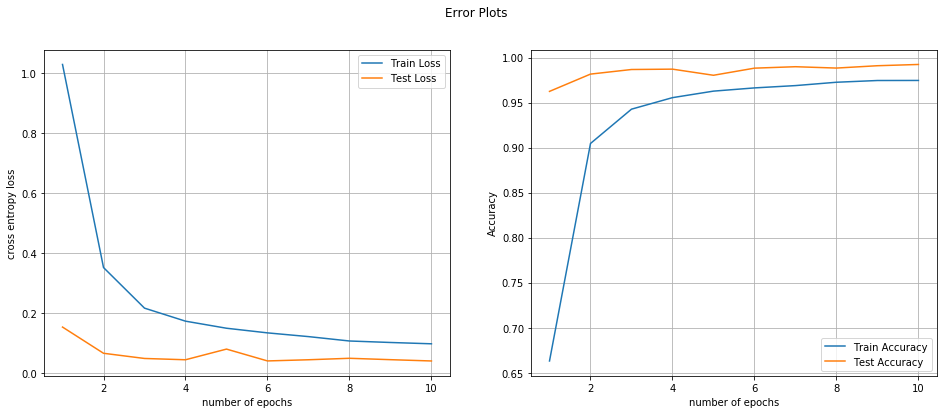

----------------------------------------------------------------------------------------------------
With batch normalization
test log-loss  0.0528347386132984
test accuracy  0.9876


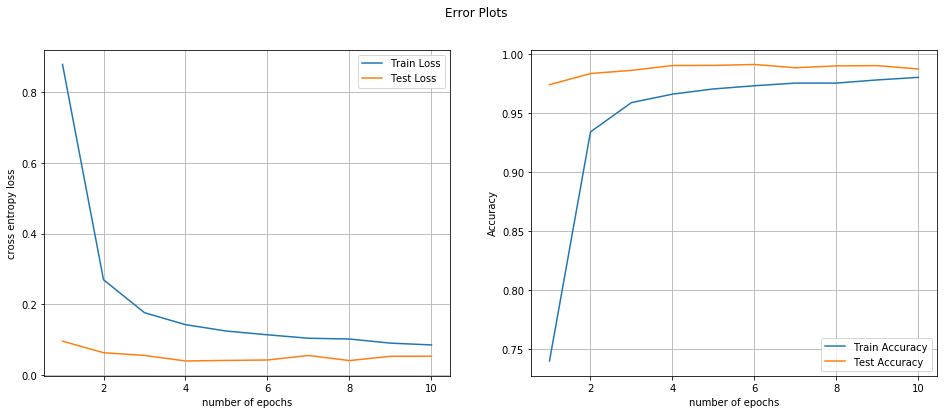

In [ ]:
print("Without Batch Normalization")
plot_graph(history5_6,model5_6)

print("-"*100)

print("With batch normalization")
plot_graph(history5_7,model5_7)



*   based On above observations we can say using batch normalization has reduced the difference between train and test loss and also the curve converges a little faster for batch normalization.




In [ ]:
print("dropout effect")
print(pt_dr)

print("\nwithout using dropout on the convolution layers :")
print("train loss ",np.round(historyn_1.history['loss'][9],2))
print("test loss ",np.round(historyn_1.history['val_loss'][9],2))

print("using dropout on convolution layers ")
print("train loss ",np.round(history5_9.history['loss'][9],2))
print("test loss ",np.round(history5_9.history['val_loss'][9],2))
      
  

dropout effect
+---------------+--------+---------+------------------+-----------+------------------+-----+--------------------+------------+-----------+---------------+
| conv2D layers | kernel | padding | maxpool/avgpool? | pool_size | num_dense_layers |  BN | Drp_out_conv_layer | train loss | test loss | test accuracy |
+---------------+--------+---------+------------------+-----------+------------------+-----+--------------------+------------+-----------+---------------+
|       3       | (5,5)  |  valid  |        No        |   (2,2)   |        3         | Yes |         No         |   0.077    |   0.041   |     0.989     |
|       3       | (5,5)  |  valid  |        No        |   (2,2)   |        2         | Yes |        0.1         |    0.07    |   0.033   |     0.992     |
|       3       | (5,5)  |  valid  |        No        |   (2,2)   |        2         | Yes |        0.5         |   0.119    |    0.03   |     0.991     |
|       3       | (5,5)  |  valid  |        No        |

* Batch normalization worked for MNIST data to improve performance.

*   As far as mnist dataset is concerned having dropout or not in both cases the model is performing similar.Large dropouts are always avoided as they always produces more loss.


---





**[4.8] Data Augmentation For MNIST dataset**

In [ ]:
print(pt_aug)

+---------------+--------+---------+----------------------+-----------+--------------+-----+---------+-------------------+------------+-----------+---------------+
| conv2D layers | kernel | padding | max_pooling/avgpool? | pool_size | dense layers |  BN | dropout | data_augmentation | train loss | test loss | test accuracy |
+---------------+--------+---------+----------------------+-----------+--------------+-----+---------+-------------------+------------+-----------+---------------+
|       3       | (5,5)  |  valid  |          No          |   (2,2)   |      3       | Yes |   0.5   |         No        |   0.119    |   0.041   |     0.989     |
|       3       | (5,5)  |  valid  |          No          |   (2,2)   |      3       | Yes |   0.5   |        Yes        |   0.485    |   0.092   |     0.973     |
+---------------+--------+---------+----------------------+-----------+--------------+-----+---------+-------------------+------------+-----------+---------------+




*   Doing data augmentation has not produced good results for MNIST dataset.

